In [1]:
import numpy as np
import matplotlib.pyplot as plt
from setup_sonar_model import setup_sonar_model, print_model_info
from simpleLeapFrog import LeapfrogSolver
from eval_g_Sonar import eval_g_Sonar
from sonar_viz import plot_pressure_xz_at
from IPython.display import display
import ipywidgets as widgets

## Test 1: Default Configuration (Horizontal Array, Center Source)

SONAR MODEL CONFIGURATION

Grid: 301 × 51 = 15,351 cells
Domain: 5625m × 938m
Spacing: dx = 18.7500m, dz = 18.7500m

Acoustic Properties:
  Sound speed: c = 1500.0 m/s
  Frequency: f₀ = 20 Hz
  Wavelength: λ = 75.00m
  Resolution: 4.0 points per wavelength
  Domain coverage: 75.0λ × 12.5λ

Source Position:
  Grid indices: (150, 25)
  Physical: x = 2812.5m, z = 468.8m

Hydrophones: 5 receivers
  Type: Horizontal array at z = 468.8m
    H1: x = 937.5m
    H2: x = 1875.0m
    H3: x = 2812.5m
    H4: x = 3750.0m
    H5: x = 4687.5m

Time Integration:
  Time span: 0.000s to 4.750s (4750.0ms)
  Max stable dt (CFL): 4419.42 μs

State Vector: 30,702 DOFs

Recommended Settings:
  ✓ CFL timestep satisfies Nyquist (limit = 25000.00 μs)
  ✓ Spatial resolution adequate (4.0 ppw ≥ 4)


(<Figure size 1200x800 with 1 Axes>,
 <Axes: title={'center': 'Sonar Simulation Domain Setup'}, xlabel='X Distance (m)', ylabel='Z Depth (m)'>)

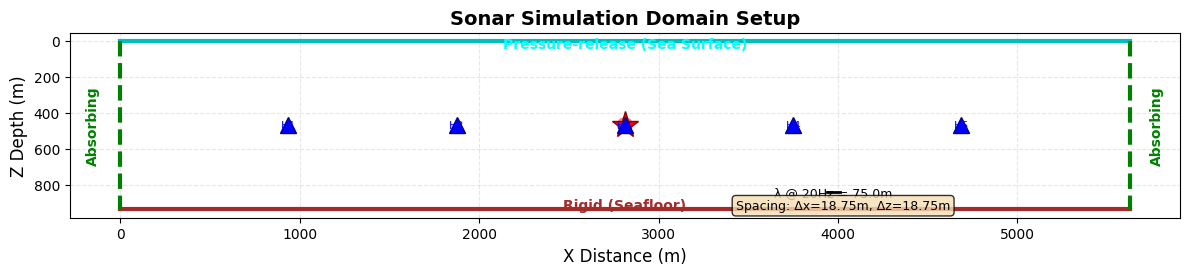

In [2]:
# Create model with default settings
model = setup_sonar_model()
print_model_info(model)

# Visualize setup
from visualize_sonar import visualize_sonar_setup
visualize_sonar_setup(model['p'], show_grid=False, show_boundary_labels=True)

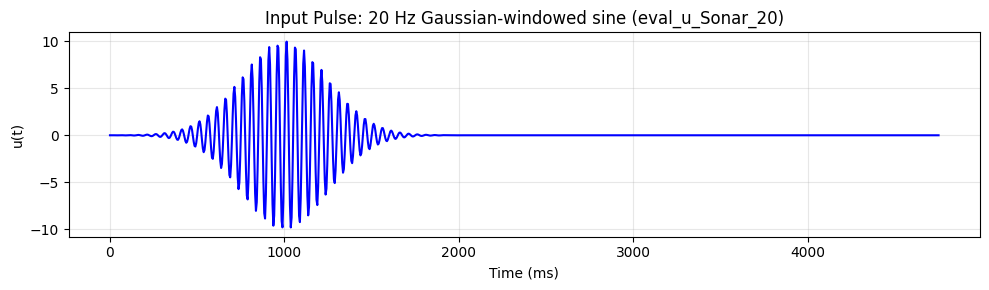

In [3]:
# Visualize the input pulse
t_test = np.linspace(model['t_start'], model['t_stop'], 1000)
u_test = [model['eval_u'](t) for t in t_test]

plt.figure(figsize=(10, 3))
plt.plot(t_test * 1000, u_test, 'b-', linewidth=1.5)
plt.xlabel('Time (ms)')
plt.ylabel('u(t)')
plt.title(f'Input Pulse: {model["f0"]} Hz Gaussian-windowed sine (eval_u_Sonar_20)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [4]:
# Run simulation
dt = model['max_dt_FE'] * 0.5  # Use 0.5x CFL timestep
num_iter = int(np.ceil((model['t_stop'] - model['t_start']) / dt))

print(f"Running {num_iter} iterations with dt = {dt*1e6:.2f} μs ({dt/model['max_dt_FE']:.2f}× CFL)")

X, t = LeapfrogSolver(
    model['eval_f'], 
    model['x_start'], 
    model['p'], 
    model['eval_u_scaled'], 
    num_iter, 
    dt=dt, 
    visualize=False
)

print(f"Simulation complete: {len(t)} timesteps, final time = {t[-1]*1000:.1f} ms")

Running 2150 iterations with dt = 2209.71 μs (0.50× CFL)
Running Leapfrog solver (stable for wave equations)...
Bootstrapping with RK4 for first step...
Running 2149 leapfrog steps...
  Progress: 10.0%
  Progress: 20.0%
  Progress: 30.0%
  Progress: 20.0%
  Progress: 30.0%
  Progress: 40.0%
  Progress: 50.0%
  Progress: 40.0%
  Progress: 50.0%
  Progress: 60.0%
  Progress: 70.0%
  Progress: 60.0%
  Progress: 70.0%
  Progress: 80.0%
  Progress: 90.0%
  Progress: 80.0%
  Progress: 90.0%
Leapfrog integration complete!
Simulation complete: 2151 timesteps, final time = 4750.9 ms
Leapfrog integration complete!
Simulation complete: 2151 timesteps, final time = 4750.9 ms


In [5]:
# Extract hydrophone data
print("Processing hydrophone data...")
num_phones = model['p']['hydrophones']['n_phones']
hydrophone_history = np.zeros((num_phones, len(t)))

for i in range(len(t)):
    y = eval_g_Sonar(X[:, i], model['p'])
    hydrophone_history[:, i] = y.flatten()

print(f"Hydrophone data shape: {hydrophone_history.shape}")

Processing hydrophone data...
Hydrophone data shape: (5, 2151)


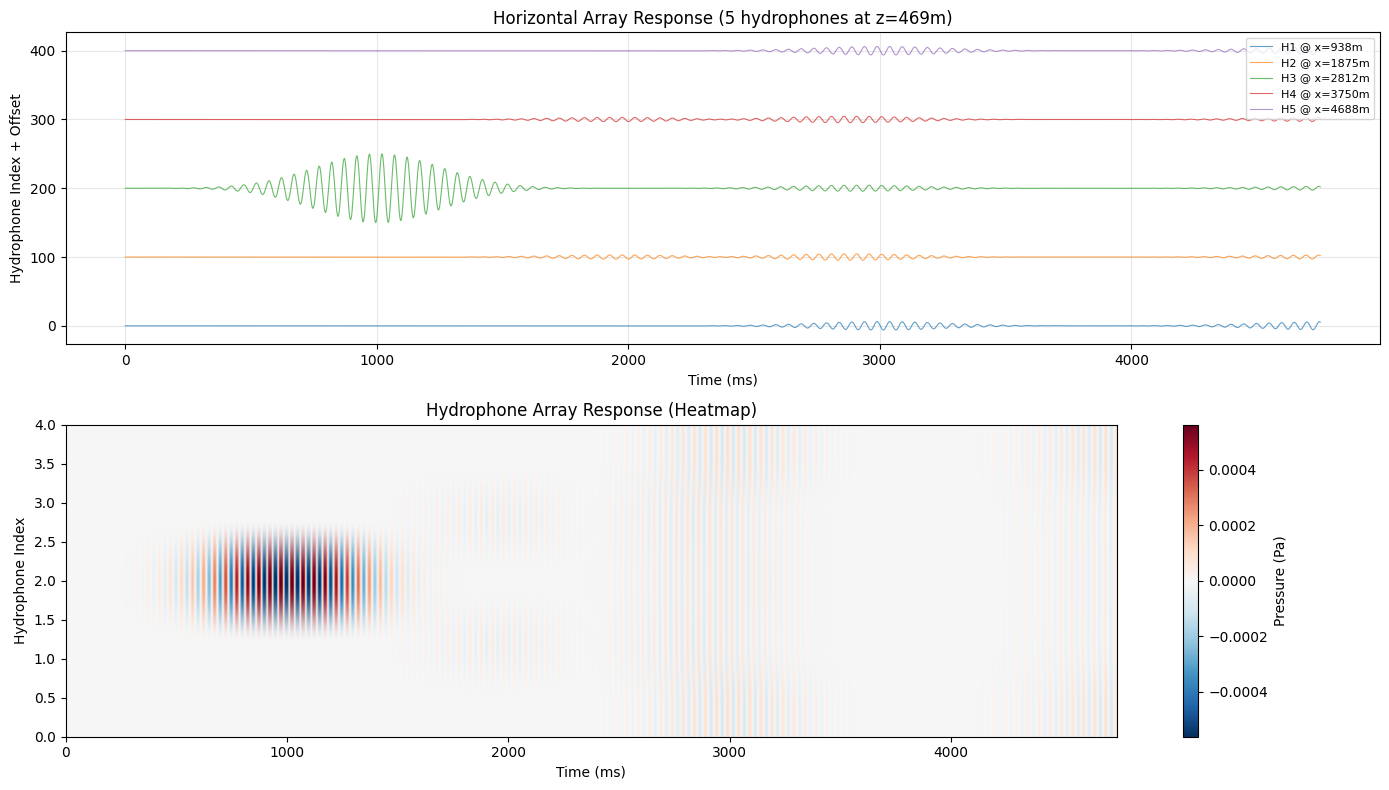

In [6]:
# Plot hydrophone responses
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8))

t_ms = np.array(t) * 1000

# Auto-scale waveform display
amp = float(np.nanmax(np.abs(hydrophone_history)) + 1e-12)
adjust_view = 50.0 / amp

# Waterfall plot
for i in range(num_phones):
    x_pos = model['hydrophones']['x_indices'][i] * model['dx']
    label = f'H{i+1} @ x={x_pos:.0f}m'
    ax1.plot(t_ms, adjust_view*hydrophone_history[i, :] + i*100, '-', alpha=0.7, linewidth=0.8, label=label)

ax1.set_xlabel('Time (ms)')
ax1.set_ylabel('Hydrophone Index + Offset')
ax1.set_title(f'Horizontal Array Response (5 hydrophones at z={model["hydrophones"]["z_pos"]*model["dz"]:.0f}m)')
ax1.grid(True, alpha=0.3)
ax1.legend(loc='upper right', fontsize=8)

# Heatmap
vmax = float(np.quantile(np.abs(hydrophone_history), 0.995) + 1e-12)
vmin = -vmax
im = ax2.imshow(hydrophone_history, aspect='auto', origin='lower',
                extent=[t_ms[0], t_ms[-1], 0, num_phones-1],
                cmap='RdBu_r', vmin=vmin, vmax=vmax)
ax2.set_xlabel('Time (ms)')
ax2.set_ylabel('Hydrophone Index')
ax2.set_title('Hydrophone Array Response (Heatmap)')
plt.colorbar(im, ax=ax2, label='Pressure (Pa)')

plt.tight_layout()
plt.show()

In [ ]:
# Interactive visualization
slider = widgets.IntSlider(
    value=len(t) - 1, 
    min=0, 
    max=X.shape[1] - 1, 
    step=1, 
    description='Timestep'
)
ui = widgets.HBox([slider])
out = widgets.interactive_output(
    lambda Index: plot_pressure_xz_at(model['p'], X, t, index=Index), 
    {'Index': slider}
)
display(ui, out)

Output()

## Test 2: Surface Source with Vertical Array

SONAR MODEL CONFIGURATION

Grid: 301 × 51 = 15,351 cells
Domain: 5625m × 938m
Spacing: dx = 18.7500m, dz = 18.7500m

Acoustic Properties:
  Sound speed: c = 1500.0 m/s
  Frequency: f₀ = 20 Hz
  Wavelength: λ = 75.00m
  Resolution: 4.0 points per wavelength
  Domain coverage: 75.0λ × 12.5λ

Source Position:
  Grid indices: (150, 1)
  Physical: x = 2812.5m, z = 18.8m

Hydrophones: 5 receivers
  Type: Vertical array at x = 2812.5m
    Depths: z = 150.0m to 768.8m

Time Integration:
  Time span: 0.000s to 4.250s (4250.0ms)
  Max stable dt (CFL): 4419.42 μs

State Vector: 30,702 DOFs

Recommended Settings:
  ✓ CFL timestep satisfies Nyquist (limit = 25000.00 μs)
  ✓ Spatial resolution adequate (4.0 ppw ≥ 4)


(<Figure size 1200x800 with 1 Axes>,
 <Axes: title={'center': 'Sonar Simulation Domain Setup'}, xlabel='X Distance (m)', ylabel='Z Depth (m)'>)

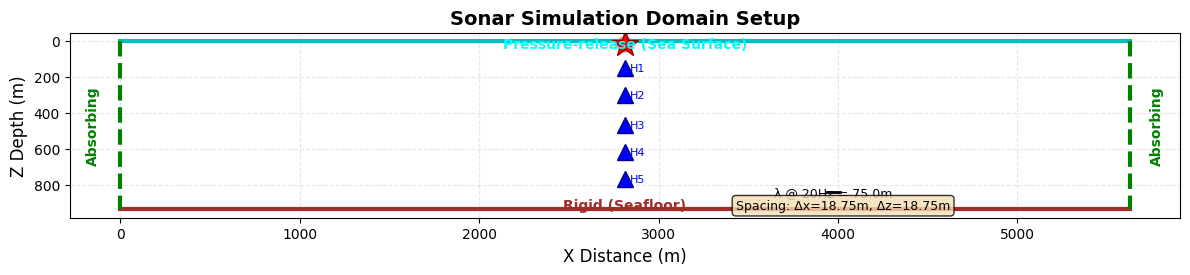

In [8]:
# Create model with surface source and vertical array
model_surf = setup_sonar_model(
    source_position='surface',
    hydrophone_config='vertical',
    t_extra=0.5
)
print_model_info(model_surf)

# Visualize setup
from visualize_sonar import visualize_sonar_setup
visualize_sonar_setup(model_surf['p'], show_grid=False, show_boundary_labels=True)

In [9]:
# Run simulation
dt_surf = model_surf['max_dt_FE'] * 0.5
num_iter_surf = int(np.ceil((model_surf['t_stop'] - model_surf['t_start']) / dt_surf))

print(f"Running {num_iter_surf} iterations with dt = {dt_surf*1e6:.2f} μs")

X_surf, t_surf = LeapfrogSolver(
    model_surf['eval_f'], 
    model_surf['x_start'], 
    model_surf['p'], 
    model_surf['eval_u_scaled'], 
    num_iter_surf, 
    dt=dt_surf, 
    visualize=False
)

print(f"Simulation complete: {len(t_surf)} timesteps")

Running 1924 iterations with dt = 2209.71 μs
Running Leapfrog solver (stable for wave equations)...
Bootstrapping with RK4 for first step...
Running 1923 leapfrog steps...
  Progress: 10.0%
  Progress: 20.0%
  Progress: 29.9%
  Progress: 20.0%
  Progress: 29.9%
  Progress: 39.9%
  Progress: 49.9%
  Progress: 39.9%
  Progress: 49.9%
  Progress: 59.9%
  Progress: 69.9%
  Progress: 59.9%
  Progress: 69.9%
  Progress: 79.8%
  Progress: 89.8%
  Progress: 79.8%
  Progress: 89.8%
  Progress: 99.8%
Leapfrog integration complete!
Simulation complete: 1925 timesteps
  Progress: 99.8%
Leapfrog integration complete!
Simulation complete: 1925 timesteps


In [10]:
# Extract vertical array data using eval_g_Sonar
print("Processing hydrophone data...")
num_phones_surf = model_surf['p']['hydrophones']['n_phones']
hydrophone_surf = np.zeros((num_phones_surf, len(t_surf)))

for i in range(len(t_surf)):
    y = eval_g_Sonar(X_surf[:, i], model_surf['p'])
    hydrophone_surf[:, i] = y.flatten()

print(f"Vertical array data shape: {hydrophone_surf.shape}")

Processing hydrophone data...
Vertical array data shape: (5, 1925)


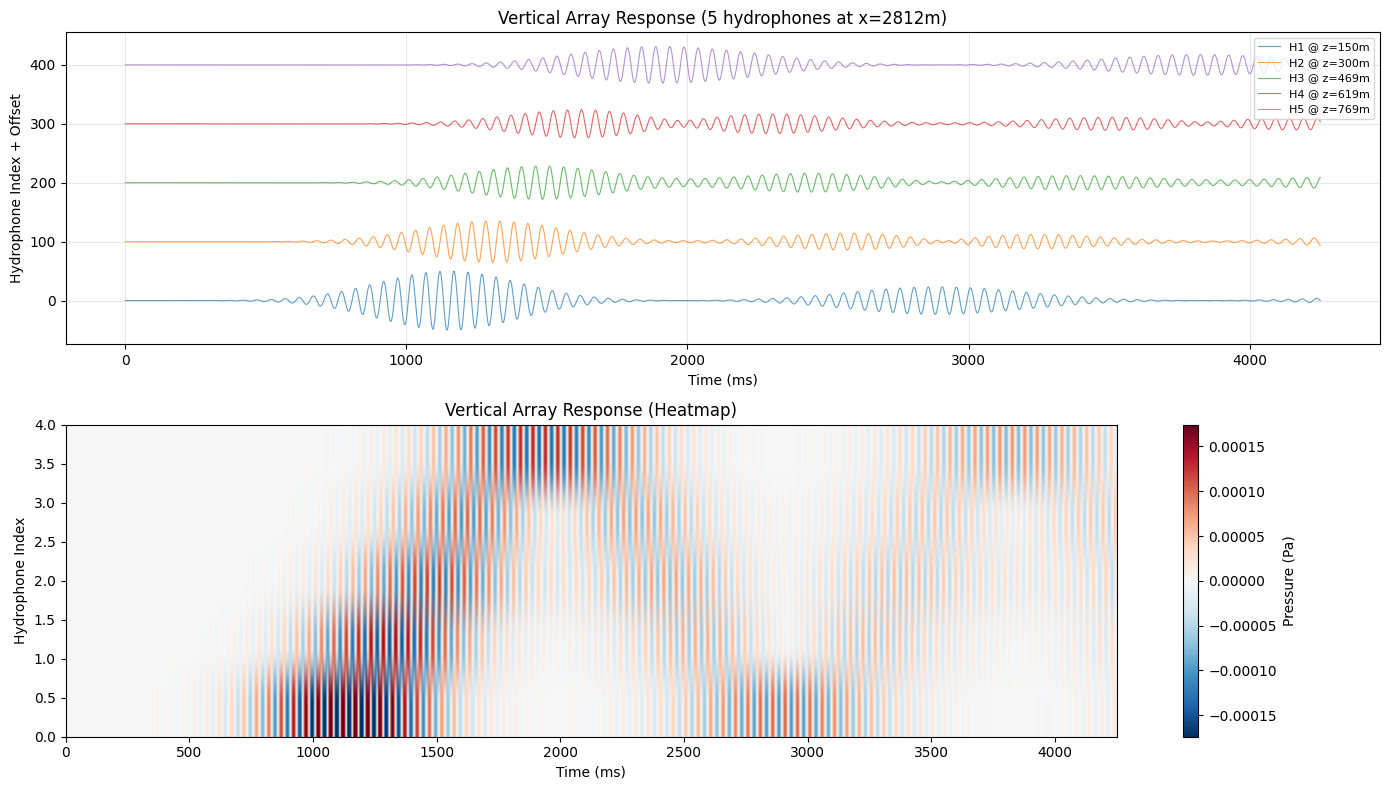

In [11]:
# Plot hydrophone responses (vertical array)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8))

t_ms_surf = np.array(t_surf) * 1000

# Auto-scale waveform display
amp_surf = float(np.nanmax(np.abs(hydrophone_surf)) + 1e-12)
adjust_view_surf = 50.0 / amp_surf

# Waterfall plot
for i in range(num_phones_surf):
    z_pos = model_surf['hydrophones']['z_indices'][i] * model_surf['dz']
    label = f'H{i+1} @ z={z_pos:.0f}m'
    ax1.plot(t_ms_surf, adjust_view_surf*hydrophone_surf[i, :] + i*100, '-', alpha=0.7, linewidth=0.8, label=label)

ax1.set_xlabel('Time (ms)')
ax1.set_ylabel('Hydrophone Index + Offset')
ax1.set_title(f'Vertical Array Response (5 hydrophones at x={model_surf["hydrophones"]["x_pos"]*model_surf["dx"]:.0f}m)')
ax1.grid(True, alpha=0.3)
ax1.legend(loc='upper right', fontsize=8)

# Heatmap
vmax_surf = float(np.quantile(np.abs(hydrophone_surf), 0.995) + 1e-12)
vmin_surf = -vmax_surf
im = ax2.imshow(hydrophone_surf, aspect='auto', origin='lower',
                extent=[t_ms_surf[0], t_ms_surf[-1], 0, num_phones_surf-1],
                cmap='RdBu_r', vmin=vmin_surf, vmax=vmax_surf)
ax2.set_xlabel('Time (ms)')
ax2.set_ylabel('Hydrophone Index')
ax2.set_title('Vertical Array Response (Heatmap)')
plt.colorbar(im, ax=ax2, label='Pressure (Pa)')

plt.tight_layout()
plt.show()

In [ ]:
# Interactive visualization (surface source)
slider_surf = widgets.IntSlider(
    value=len(t_surf) - 1, 
    min=0, 
    max=X_surf.shape[1] - 1, 
    step=1, 
    description='Timestep'
)
ui_surf = widgets.HBox([slider_surf])
out_surf = widgets.interactive_output(
    lambda Index: plot_pressure_xz_at(model_surf['p'], X_surf, t_surf, index=Index), 
    {'Index': slider_surf}
)
display(ui_surf, out_surf)

Output()

In [13]:
# Check surface boundary condition
Nz_surf = model_surf['Nz']
surface_p = X_surf[0::Nz_surf, :]
print(f"\nSurface pressure (should be ~0):")
print(f"  min = {surface_p.min():.2e} Pa")
print(f"  max = {surface_p.max():.2e} Pa")
print(f"  mean abs = {np.abs(surface_p).mean():.2e} Pa")


Surface pressure (should be ~0):
  min = 0.00e+00 Pa
  max = 0.00e+00 Pa
  mean abs = 0.00e+00 Pa


## Test 3: Custom Configuration (Smaller Domain)

SONAR MODEL CONFIGURATION

Grid: 151 × 31 = 4,681 cells
Domain: 2812m × 562m
Spacing: dx = 18.7500m, dz = 18.7500m

Acoustic Properties:
  Sound speed: c = 1500.0 m/s
  Frequency: f₀ = 20 Hz
  Wavelength: λ = 75.00m
  Resolution: 4.0 points per wavelength
  Domain coverage: 37.5λ × 7.5λ

Source Position:
  Grid indices: (75, 15)
  Physical: x = 1406.2m, z = 281.2m

Hydrophones: 5 receivers
  Type: Horizontal array at z = 281.2m
    H1: x = 468.8m
    H2: x = 937.5m
    H3: x = 1406.2m
    H4: x = 1875.0m
    H5: x = 2343.8m

Time Integration:
  Time span: 0.000s to 2.175s (2175.0ms)
  Max stable dt (CFL): 4419.42 μs

State Vector: 9,362 DOFs

Recommended Settings:
  ✓ CFL timestep satisfies Nyquist (limit = 25000.00 μs)
  ✓ Spatial resolution adequate (4.0 ppw ≥ 4)


(<Figure size 1200x800 with 1 Axes>,
 <Axes: title={'center': 'Sonar Simulation Domain Setup'}, xlabel='X Distance (m)', ylabel='Z Depth (m)'>)

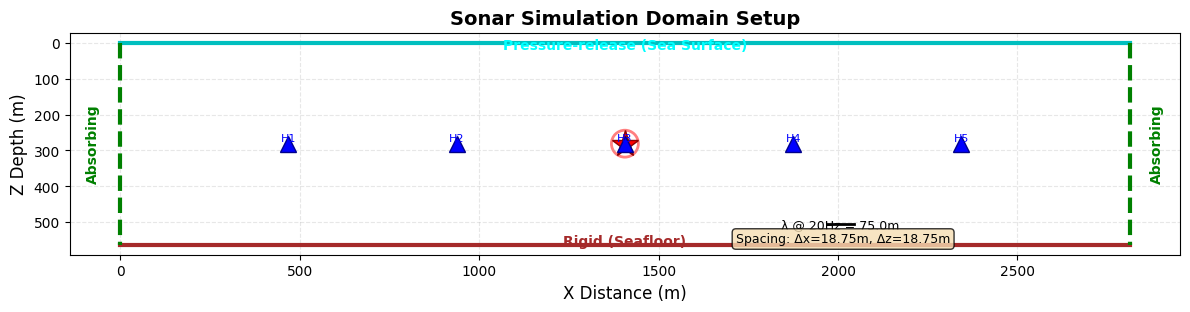

In [14]:
# Create smaller, faster model for testing
model_small = setup_sonar_model(
    Nx=151,
    Nz=31,
    Lx=2812.5,  # Keep 4 ppw
    Lz=562.5,
    source_position='center',
    hydrophone_config='horizontal',
    t_extra=0.3
)
print_model_info(model_small, verbose=True)

# Visualize setup
from visualize_sonar import visualize_sonar_setup
visualize_sonar_setup(model_small['p'], show_grid=False, show_boundary_labels=True)

In [15]:
# Quick simulation
dt_small = model_small['max_dt_FE'] * 0.5
num_iter_small = int(np.ceil((model_small['t_stop'] - model_small['t_start']) / dt_small))

print(f"Running {num_iter_small} iterations...")

X_small, t_small = LeapfrogSolver(
    model_small['eval_f'], 
    model_small['x_start'], 
    model_small['p'], 
    model_small['eval_u_scaled'], 
    num_iter_small, 
    dt=dt_small, 
    visualize=False
)

print(f"Complete! State vector: {X_small.shape}")

Running 985 iterations...
Running Leapfrog solver (stable for wave equations)...
Bootstrapping with RK4 for first step...
Running 984 leapfrog steps...
  Progress: 9.9%
  Progress: 19.9%
  Progress: 29.8%
  Progress: 39.8%
  Progress: 49.7%
  Progress: 59.7%
  Progress: 69.6%
  Progress: 79.6%
  Progress: 89.5%
  Progress: 99.5%
Leapfrog integration complete!
Complete! State vector: (9362, 986)
  Progress: 99.5%
Leapfrog integration complete!
Complete! State vector: (9362, 986)


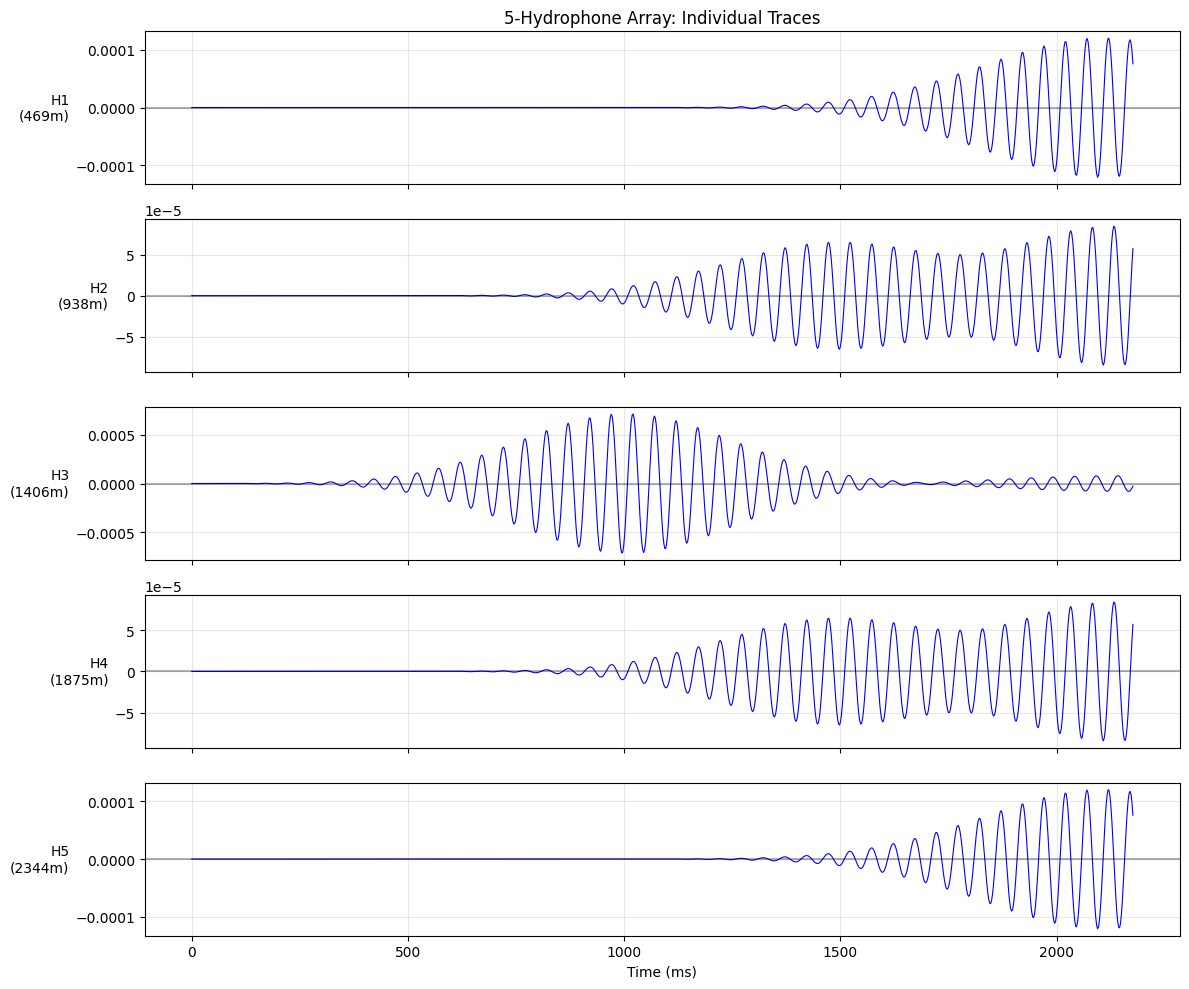

In [16]:
# Extract and plot hydrophone data
num_phones_small = model_small['hydrophones']['n_phones']
hydrophone_small = np.zeros((num_phones_small, len(t_small)))

for i in range(len(t_small)):
    y = eval_g_Sonar(X_small[:, i], model_small['p'])
    hydrophone_small[:, i] = y.flatten()

# Plot individual traces
fig, axes = plt.subplots(num_phones_small, 1, figsize=(12, 10), sharex=True)
t_ms_small = np.array(t_small) * 1000

for i in range(num_phones_small):
    x_pos = model_small['hydrophones']['x_indices'][i] * model_small['dx']
    axes[i].plot(t_ms_small, hydrophone_small[i, :], 'b-', linewidth=0.8)
    axes[i].set_ylabel(f'H{i+1}\n({x_pos:.0f}m)', rotation=0, ha='right', va='center')
    axes[i].grid(True, alpha=0.3)
    axes[i].axhline(0, color='k', linestyle='-', alpha=0.3)

axes[-1].set_xlabel('Time (ms)')
axes[0].set_title('5-Hydrophone Array: Individual Traces')
plt.tight_layout()
plt.show()

## Summary

The `setup_sonar_model` wrapper function successfully:
- Creates consistent model configurations with proper grid resolution (4 ppw)
- Uses `eval_u_Sonar_20` (time-varying 20Hz signal)
- Supports multiple source positions ('center', 'surface', custom)
- Supports multiple hydrophone arrays ('horizontal', 'vertical')
- Provides all necessary functions and parameters for simulation
- Validates configuration with diagnostic output